In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
model = load_model('models/CNN_69%_72epsES.h5') # pre-trained network
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 48, 48, 256)       2560      
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 512)       1180160   
                                                                 
 batch_normalization_15 (Bat  (None, 48, 48, 512)      2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 512)      0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 24, 24, 512)       0   

In [3]:
# data preprocessing - test 

test_path = 'test'

test_datagen = ImageDataGenerator(
    rescale = 1 / 255.0
)

test_gen = test_datagen.flow_from_directory(
    directory = test_path,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

Found 3589 images belonging to 7 classes.


In [4]:
model.evaluate(test_gen)

57/57 [==============================] - 17s 175ms/step - loss: 0.8969 - acc: 0.6879


[0.8969001173973083, 0.6879353523254395]

In [5]:
# perform predictions
true_labels = [] 
predicted_labels = []

for i in range(len(test_gen)):
    test_data, test_labels = next(test_gen) 
    true_labels.extend(np.argmax(test_labels, axis=1))
    predictions = model.predict(test_data, verbose = 0)
    predicted_labels.extend(np.argmax(predictions, axis=1))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

In [6]:
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       491
           1       0.59      0.71      0.64        55
           2       0.63      0.44      0.52       528
           3       0.84      0.91      0.87       879
           4       0.58      0.48      0.53       594
           5       0.80      0.80      0.80       416
           6       0.59      0.74      0.66       626

    accuracy                           0.69      3589
   macro avg       0.66      0.67      0.66      3589
weighted avg       0.68      0.69      0.68      3589



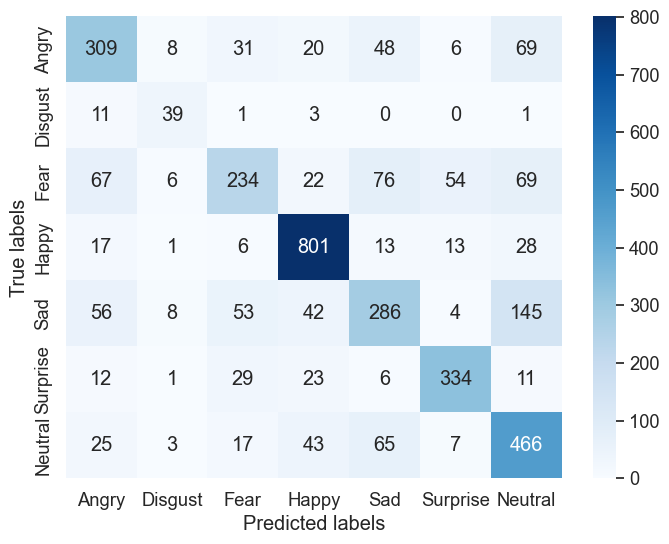

In [7]:
cm = confusion_matrix(true_labels, predicted_labels)

class_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

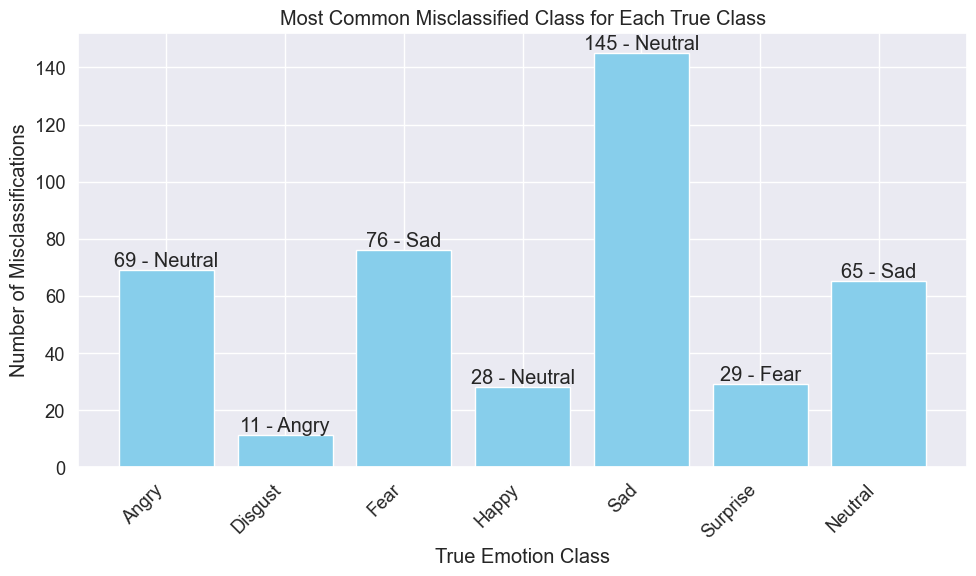

In [8]:
max_misclassification_count = []
misclassification_classes = []

for true_class, row in enumerate(cm):
    row[true_class] = 0
    max_misclassification_idx = np.argmax(row)
    max_misclassification_count.append(row[max_misclassification_idx])
    misclassification_classes.append(max_misclassification_idx)
    
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 6))
plt.bar(class_names, max_misclassification_count, color='skyblue')
plt.xlabel('True Emotion Class')
plt.ylabel('Number of Misclassifications')
plt.title('Most Common Misclassified Class for Each True Class')
plt.xticks(rotation=45, ha='right')
for i in range(len(class_names)):
    plt.text(i, max_misclassification_count[i], f'{max_misclassification_count[i]} - {class_names[misclassification_classes[i]]}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

In [100]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
explainer = lime_image.LimeImageExplainer(verbose = 0)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)
import cv2

emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

def LIMEexplainer(image, exp_array):
    explanation = explainer.explain_instance(image.astype('double'), classifier_fn = model.predict, top_labels=7, hide_color=0, num_samples=1000, segmentation_fn=segmenter);
    exp_array.append(explanation)

def masks(images, true_labels, pred_labels, exp_array):
    for i in range(len(images)):    
        temp, mask = exp_array[i].get_image_and_mask(true_labels[i], positive_only=True, num_features=30, hide_rest=False)
        backtorgb = cv2.cvtColor(temp.astype('float32'),cv2.COLOR_GRAY2RGB)
        
        plt.figure(figsize=(15, 10))
        
        # Plot the original grayscale image
        plt.subplot(1, 4, 1)
        plt.imshow(images[i].reshape(48, 48), cmap="gray")
        plt.title('Original - Predicted: {}, True: {}'.format(emotion_dict[pred_labels[i]], emotion_dict[true_labels[i]]))
        plt.axis('off')
        
        # Plot the positive regions overlaid with colors
        plt.subplot(1, 4, 2)
        plt.imshow(label2rgb(mask, backtorgb, bg_label=0), interpolation='nearest')
        plt.title('Positive Regions for {}'.format(emotion_dict[true_labels[i]]))
        plt.axis('off')
        
        # Plot the positive regions with boundaries
        temp, mask = exp_array[i].get_image_and_mask(true_labels[i], positive_only=True, num_features=30, hide_rest=True)
        plt.subplot(1, 4, 3)
        plt.imshow(mark_boundaries(temp.reshape(48, 48) / 2 + 0.5, mask), cmap='gray')
        plt.title('Pixels Positively Contributing')
        plt.axis('off')
        
        # Plot the negative regions with boundaries
        temp, mask = exp_array[i].get_image_and_mask(true_labels[i], positive_only=False, negative_only=True, num_features=10, hide_rest=True)
        plt.subplot(1, 4, 4)
        plt.imshow(mark_boundaries(temp.reshape(48, 48) / 2 + 0.5, mask), cmap='gray')
        plt.title('Pixels Negatively Contributing')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


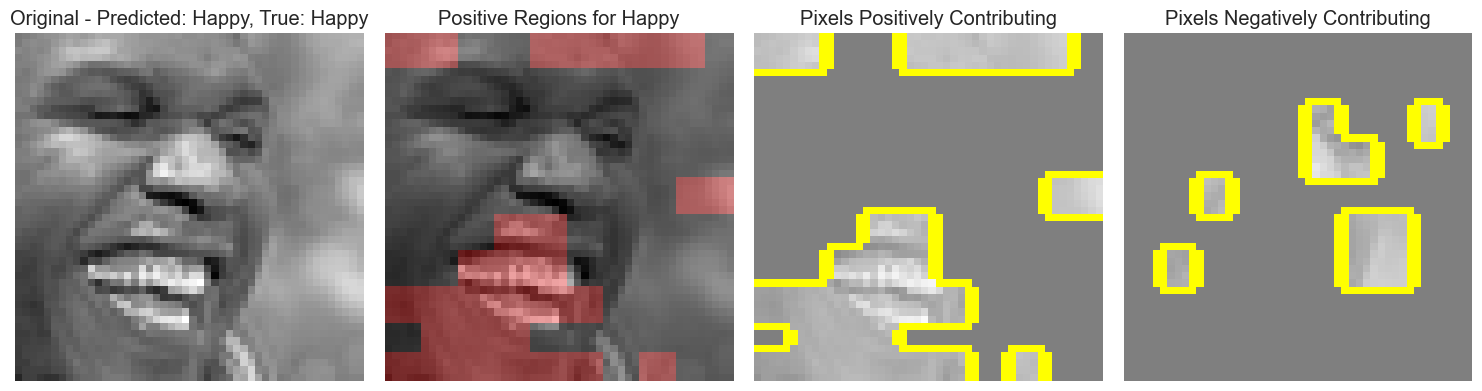

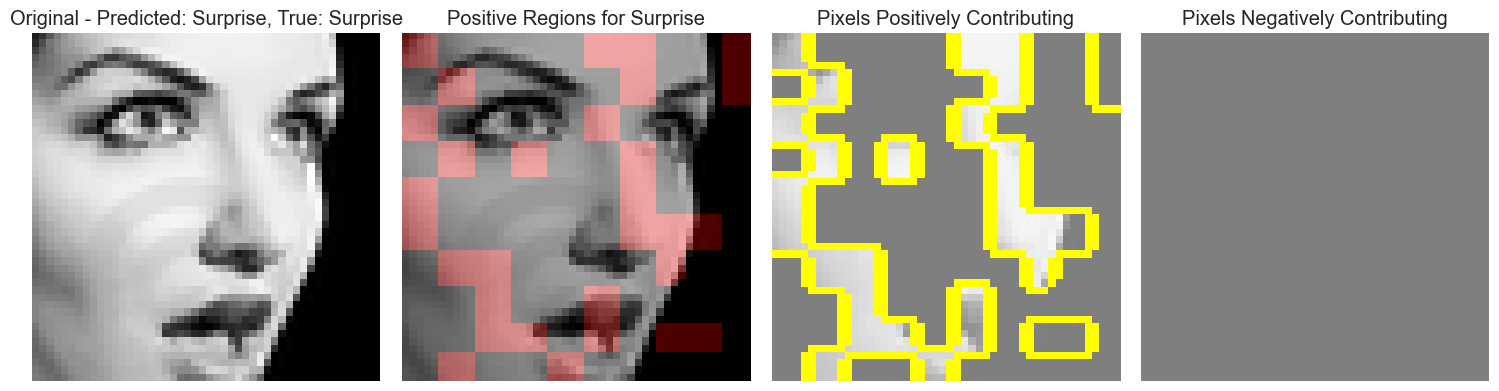

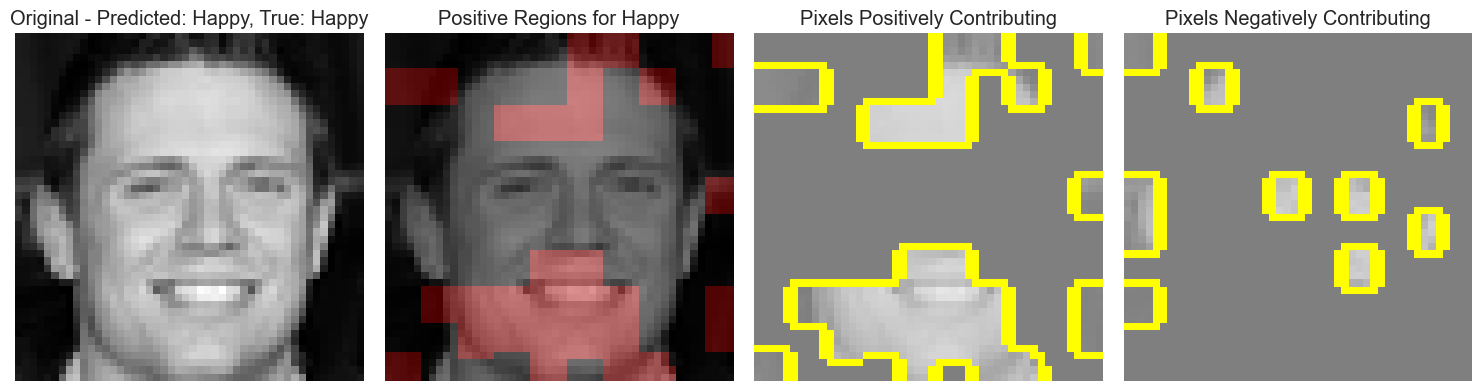

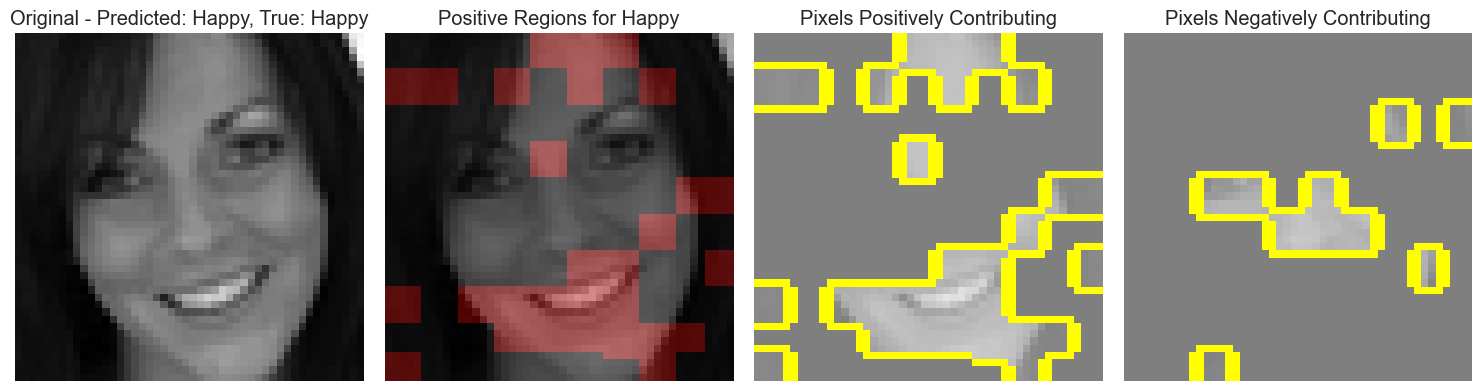

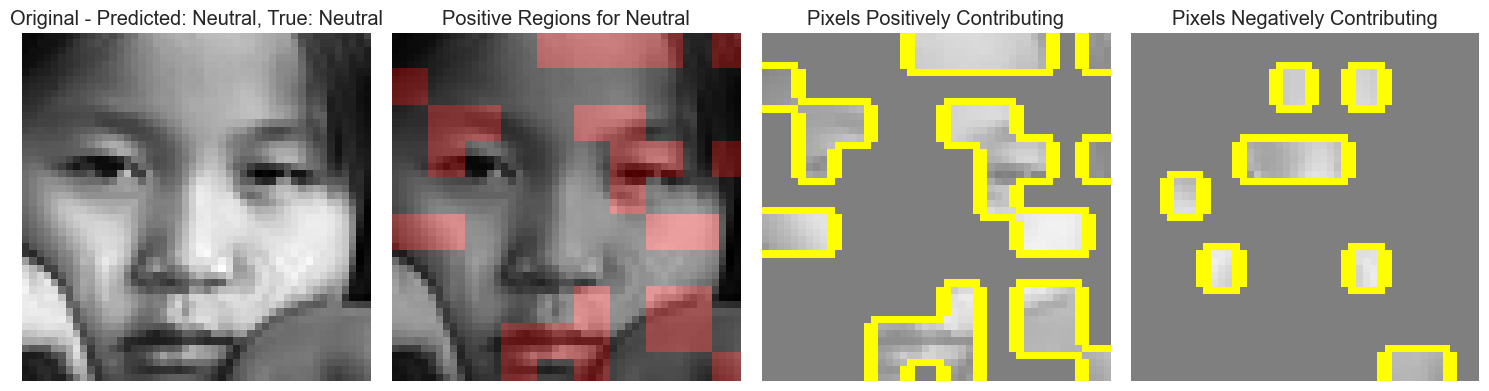

In [102]:
test_data, test_labels = next(test_gen)

# Perform predictions
predictions = model.predict(test_data, verbose=0)
true_labels = np.argmax(test_labels, axis=1)
pred_labels = np.argmax(predictions, axis=1)

exp_array = []
correct_labels = []
predicted_labels = []
images = []
samples = 0

for i, (true_label, pred_label) in enumerate(zip(true_labels, pred_labels)):
    if true_label == pred_label:
        image = test_data[i]
        images.append(image)
        LIMEexplainer(image, exp_array)
        correct_labels.append(true_label)
        predicted_labels.append(pred_label)

        samples += 1
        if samples == 5:
            break

masks(images,correct_labels, predicted_labels, exp_array)